# H3 Data processing performance

The idea of this notebook is to check the performance that we can get doing summary statistics in one location using h3 vs the one that we can get doing the summary statistics directly to the raster file.

In [1]:
# import libraries
import pandas as pd
import geopandas as gpd
import h3
import json
from shapely.geometry import shape, mapping

In [2]:
import rasterio as rio
import rasterio.plot
import matplotlib.pyplot as plt
from rasterstats import gen_zonal_stats, gen_point_query
from rasterstats import zonal_stats

In [3]:
import time

In [4]:
from processing.geolocating_data import GeolocateAddress

In [5]:
# import user located data
user_data_polygon = gpd.read_file('../../datasets/processed/located_lg_data_polygon_v2.shp')
user_data_polygon.head()



,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,Rubber,None,2400,China,None,None,None,Unknown,Low,"MULTIPOLYGON (((73.49973 39.38174, 73.50468 39..."
1,Rubber,None,1300,Malaysia,None,None,None,Unknown,Low,"MULTIPOLYGON (((98.93721 5.68384, 98.93771 5.6..."
2,Rubber,None,1000,United States,None,None,None,Unknown,Low,"MULTIPOLYGON (((-180.00000 51.79409, -180.0000..."
3,Rubber,None,730,Japan,None,None,None,Unknown,Low,"MULTIPOLYGON (((122.71418 24.44983, 122.71457 ..."
4,Rubber,None,490,India,None,None,None,Unknown,Low,"MULTIPOLYGON (((68.11138 23.60145, 68.13528 23..."


In [146]:
set(list(user_data_polygon['Material']))

{'Cotton', 'Leather', 'Rubber'}

In [154]:
user_data_polygon[user_data_polygon['Material']=='Cotton'].iloc[4]

Material                                                 Cotton
Material d                                                 None
Volume                                                      745
Country                                                   India
Address                                                    None
Latitude                                                   None
Longitude                                                  None
Location t                                              Unknown
Accuracy                                                    Low
geometry      (POLYGON ((68.1113787 23.6014507, 68.135278 23...
Name: 18, dtype: object

In [156]:
#lest select just one admin level 3 of india to reduce the computational time - this has been obtained from gadm
polygon_gdf = gpd.read_file('../../datasets/raw/Punjab_adm.shp')
polygon_gdf

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,IND,India,IND.28_1,Punjab,None,IND.28.13_1,Mansa,None,IND.28.13.1_1,Mansa,None,None,Taluk,Taluk,None,None,"POLYGON ((75.34850 29.65907, 75.34681 29.65889..."


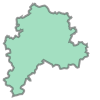

In [158]:
#select test location to perform calculations

polygon = polygon_gdf.iloc[0]['geometry']
polygon

In [5]:
## import basins shapefile to test with front

basins = gpd.read_file('../../datasets/raw/basins_test_polygon.shp')
basins.head()

,BASWC4_ID,ID,N,NAME,CONT,NN,FISH_,ACRES,SOURCETHM,NO_COUNTRI,Q3,CHECKED,LAEA_HA,LAEA_ACRES,LAEA_PRMTR,union_id,geometry
0,2,408,11,Indigirka,2,2011,0,0.002,geoff2.dbf,0,None,-1,0.0,0.0,0.0,1,"POLYGON ((-67.63902 -53.80524, -67.67741 -53.8..."
1,2,408,11,Indigirka,2,2011,0,0.002,geoff2.dbf,0,None,-1,0.0,0.0,0.0,1,"POLYGON ((-68.94494 -51.54272, -68.94863 -51.5..."
2,2,408,11,Indigirka,2,2011,0,0.002,geoff2.dbf,0,None,-1,0.0,0.0,0.0,1,"POLYGON ((139.16783 -35.35792, 139.08195 -35.2..."
3,2,408,11,Indigirka,2,2011,0,0.002,geoff2.dbf,0,None,-1,0.0,0.0,0.0,1,"POLYGON ((-71.36697 -44.38985, -71.39011 -44.3..."
4,2,408,11,Indigirka,2,2011,0,0.002,geoff2.dbf,0,None,-1,0.0,0.0,0.0,1,"POLYGON ((46.33815 -15.96432, 46.33733 -15.955..."


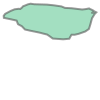

In [20]:
basins['geometry'][0]

## Retrieve gadm data and import raster to perform calculations

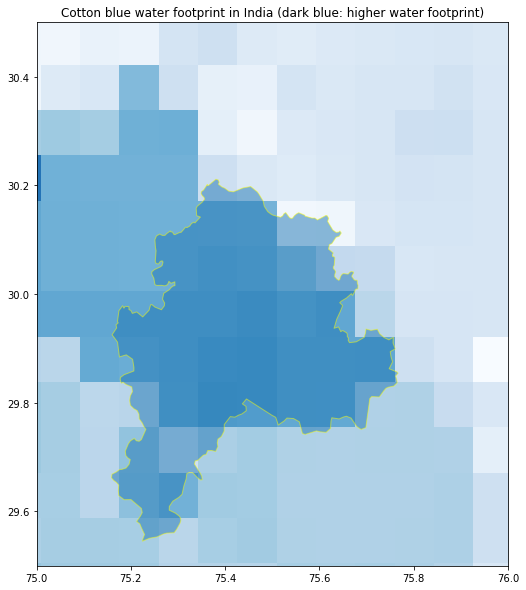

In [173]:
#import blue water footprint cotton
with rio.open('../../datasets/raw/wfbl_mmyr_4326_cotton.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((29.5,30.5))
    ax.set_xlim((75,76))
    rio.plot.show(dat, vmin=0, vmax=444, cmap='Blues', ax=ax, transform=src.transform)
    polygon_gdf.plot(ax=ax, alpha=0.5, edgecolor='yellow')
    ax.set_title('Cotton blue water footprint in India (dark blue: higher water footprint)')

## Transform user data to h3

Trandform data to h3 resolution 8 (base resolution would be something to explore latter on the process)

In [9]:
def generate_h3_df(geometry, res):
    """
    Generate h3 for geometry
    
    Input
    ------
    geometry: shapely.polygon or shapely.multipolygon
    
    Output
    ------
    gdf with H3_hexes
    """
    # Create an empty dataframe to write data into
    h3_df = pd.DataFrame([],columns=['h3_id'])
    if geometry.geom_type == 'MultiPolygon':
        district_polygon = list(geometry)
        for polygon in district_polygon:
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
            poly_geojson = poly_geojson['features'][0]['geometry'] 
            h3_hexes = h3.polyfill_geojson(poly_geojson, res)
            for h3_hex in h3_hexes:
                h3_df.loc[len(h3_df)]=[
                        h3_hex
                    ]
    elif geometry.geom_type == 'Polygon':
        poly_geojson = gpd.GeoSeries(geometry).__geo_interface__
        poly_geojson = poly_geojson['features'][0]['geometry']
        h3_hexes = h3.polyfill_geojson(poly_geojson, res)
        for h3_hex in h3_hexes:
            h3_df.loc[len(h3_df)]=[
                    h3_hex
                ]
    else:
        print('Shape is not a polygon or multypolygon.')
        
    return h3_df


In [7]:
def generate_h3_features(geometry, res):
    """
    Generate h3 for geometry
    
    Input
    ------
    geometry: shapely.polygon or shapely.multipolygon
    
    Output
    ------
    gdf with H3_hexes
    """
    # Create an empty dataframe to write data into
    h3_df = pd.DataFrame([],columns=['h3_id'])
    if geometry.geom_type == 'MultiPolygon':
        district_polygon = list(geometry)
        for polygon in district_polygon:
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
            poly_geojson = poly_geojson['features'][0]['geometry'] 
            h3_hexes = h3.polyfill_geojson(poly_geojson, res)
            for h3_hex in h3_hexes:
                coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
                yield {
                    "type": "Feature",
                    "properties": {"hexid": h3_hex},
                    "geometry": {"type": "Polygon", "coordinates": coords[0]},
                }
    elif geometry.geom_type == 'Polygon':
        poly_geojson = gpd.GeoSeries(geometry).__geo_interface__
        poly_geojson = poly_geojson['features'][0]['geometry']
        h3_hexes = h3.polyfill_geojson(poly_geojson, res)
        for h3_hex in h3_hexes:
            coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
            yield {
                "type": "Feature",
                "properties": {"hexid": h3_hex},
                "geometry": {"type": "Polygon", "coordinates": coords[0]},
            }
    else:
        print('Shape is not a polygon or multypolygon.')
        
    
        

In [137]:
## time to process the entire malasya
start_time = time.time()
h3_adm_df = generate_h3_df(user_data_polygon['geometry'][1], 8)
print("--- %s seconds ---" % (time.time() - start_time))

--- 11550.898565769196 seconds ---


In [174]:
## time to process the test geometry - 
start_time = time.time()
h3_adm_df = generate_h3_df(polygon, 8)
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.8183064460754395 seconds ---


In [175]:
h3_adm_df.head()

,h3_id
0,88424b3149fffff
1,88424b2233fffff
2,88424b3263fffff
3,88424baa19fffff
4,88424ba837fffff


In [67]:
#time spend in generating the features in h3 for Malasya
start_time = time.time()
h3_features = generate_h3_features(test_location['geometry'], 8)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0009725093841552734 seconds ---


In [177]:
#time spend in generating the features in h3 for the test polygon
start_time = time.time()
h3_features = generate_h3_features(polygon, 8)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00016045570373535156 seconds ---


In [54]:
#time spend in generating the features in h3 for the basins test in resolution 1
start_time = time.time()
h3_features = [generate_h3_features(poly, 4) for poly in basins['geometry']]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0002689361572265625 seconds ---


In [94]:
#time spend in generating the features in h3 for the basins test in resolution 1
start_time = time.time()
h3_features_res5 = [generate_h3_features(poly, 5) for poly in basins['geometry']]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00037550926208496094 seconds ---


In [51]:
#time spend in generating the features in h3 for the basins test in resolution 1
start_time = time.time()
h3_features_res7 = [generate_h3_features(poly, 7) for poly in basins['geometry']]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00037384033203125 seconds ---


## Perform raster summary statistics to h3

In [55]:

#summary statistics world main basins
start_time = time.time()
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
# Outputs hexbin feautres with additional properties: "population_sum": <float>
summ_stats_h3 = [gen_zonal_stats(
    generator,
    raster_path,
    stats="max",
    prefix="m_",
    geojson_out=True,
    all_touched=True
    ) for generator in h3_features]
    
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00022745132446289062 seconds ---


In [95]:

#summary statistics world main basins
start_time = time.time()
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
# Outputs hexbin feautres with additional properties: "population_sum": <float>
summ_stats_h3_res5 = [gen_zonal_stats(
    generator,
    raster_path,
    stats="max",
    prefix="m_",
    geojson_out=True,
    all_touched=True
    ) for generator in h3_features_res5]
    
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0011000633239746094 seconds ---


In [52]:

#summary statistics world main basins
start_time = time.time()
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
# Outputs hexbin feautres with additional properties: "population_sum": <float>
summ_stats_h3_res7 = [gen_zonal_stats(
    generator,
    raster_path,
    stats="max",
    prefix="m_",
    geojson_out=True,
    all_touched=True
    ) for generator in h3_features_res7]
    
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0002224445343017578 seconds ---


In [140]:
#summary statistics in malasya
start_time = time.time()
hexbin_generator = generate_h3_features(user_data_polygon['geometry'][1], 8)
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
# Outputs hexbin feautres with additional properties: "population_sum": <float>
summ_stats_h3 = gen_zonal_stats(
    hexbin_generator,
    raster_path,
    stats="median std",
    prefix="wfbl_mmyr_cotton",
    geojson_out=True,
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0004067420959472656 seconds ---


In [320]:
#summary statistics in test geometry - adm level 3
start_time = time.time()
hexbin_generator = generate_h3_features(polygon, 8)
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
# Outputs hexbin feautres with additional properties: "population_sum": <float>
summ_stats_h3 = gen_zonal_stats(
    hexbin_generator,
    raster_path,
    stats="median std",
    prefix="wfbl_mmyr_cotton",
    geojson_out=True,
    all_touched=True
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00018143653869628906 seconds ---


In [242]:
#summary statistics in test geometry - adm level 3
start_time = time.time()
hexbin_generator = generate_h3_features(polygon, 4)
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
# Outputs hexbin feautres with additional properties: "population_sum": <float>
summ_stats_h3_res4 = gen_zonal_stats(
    hexbin_generator,
    raster_path,
    stats="median std",
    prefix="wfbl_mmyr_cotton",
    geojson_out=True,
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00015807151794433594 seconds ---


In [248]:
#summary statistics in test geometry - adm level 3
start_time = time.time()
hexbin_generator = generate_h3_features(polygon, 6)
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
# Outputs hexbin feautres with additional properties: "population_sum": <float>
summ_stats_h3_res6 = gen_zonal_stats(
    hexbin_generator,
    raster_path,
    stats="median std",
    prefix="wfbl_mmyr_cotton",
    geojson_out=True,
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00035762786865234375 seconds ---


In [254]:
#summary statistics in test geometry - adm level 3
start_time = time.time()
hexbin_generator = generate_h3_features(polygon, 5)
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
# Outputs hexbin feautres with additional properties: "population_sum": <float>
summ_stats_h3_res5 = gen_zonal_stats(
    hexbin_generator,
    raster_path,
    stats="median std",
    prefix="wfbl_mmyr_cotton",
    geojson_out=True,
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00018715858459472656 seconds ---


In [201]:
#summary statistics in test geometry - adm level 3
start_time = time.time()
hexbin_generator = generate_h3_features(polygon, 8)
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
zs_h3= zonal_stats(
    hexbin_generator,
    raster_path,
    stats="median")
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.697538137435913 seconds ---


In [327]:
#summary statistics in test geometry - adm level 3
start_time = time.time()
hexbin_generator = generate_h3_features(polygon, 6)
raster_path = '../../datasets/raw/wfbl_mmyr_4326_cotton.tif'
gpq_stats_h3_res6 = gen_point_query(
    hexbin_generator,
    raster_path,
    interpolate = 'nearest',
    property_name = 'bl_gpq_',
    geojson_out=True,
    )
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0002117156982421875 seconds ---


In [78]:
# check features of basins worldwide
for generator in summ_stats_h3:
    for feature in generator:
        print(feature['properties']['m_max'])
        break

0.0
0.0
0.0
0.0
0.0
5.906078815460205
0.0
0.8325069546699524
6.0060577392578125


In [141]:
for feature in summ_stats_h3:
    print(feature)
    break

{'type': 'Feature', 'properties': {'hexid': '8865332619fffff', 'wfbl_mmyr_cottonmedian': None, 'wfbl_mmyr_cottonstd': None}, 'geometry': {'type': 'Polygon', 'coordinates': [[(103.61852853359406, 4.52646727450434), (103.61903125829339, 4.531621009297402), (103.61482726722974, 4.534579118931786), (103.61012049989567, 4.532383356329096), (103.60961789380929, 4.527229499598597), (103.61382193643503, 4.524271527398861), (103.61852853359406, 4.52646727450434)]]}}


In [321]:
for feature in summ_stats_h3:
    print(feature)
    break

{'type': 'Feature', 'properties': {'hexid': '88424b3149fffff', 'wfbl_mmyr_cottonstd': 0.0, 'wfbl_mmyr_cottonmedian': 260.7225036621094}, 'geometry': {'type': 'Polygon', 'coordinates': [[(75.40239503652334, 29.81948574978886), (75.39764864032557, 29.816639039950726), (75.39817635833043, 29.811822088213038), (75.40344974275206, 29.809851798859498), (75.40819586100108, 29.81269811591374), (75.40766887279375, 29.817515115072045), (75.40239503652334, 29.81948574978886)]]}}


In [243]:
for feature in summ_stats_h3_res4:
    print(feature)
    break

{'type': 'Feature', 'properties': {'hexid': '84424b3ffffffff', 'wfbl_mmyr_cottonstd': 49.00380258350497, 'wfbl_mmyr_cottonmedian': 153.57852172851562}, 'geometry': {'type': 'Polygon', 'coordinates': [[(75.86840220674935, 29.662738501442483), (75.84420862215558, 29.898688749544057), (75.58586534096533, 29.995983063676597), (75.35278965832148, 29.85648869000121), (75.37873398732214, 29.620643180138938), (75.63600509751178, 29.524183374656037), (75.86840220674935, 29.662738501442483)]]}}


In [250]:
for feature in summ_stats_h3_res6:
    print(feature)
    break

{'type': 'Feature', 'properties': {'hexid': '86424b22fffffff', 'wfbl_mmyr_cottonstd': 0.0, 'wfbl_mmyr_cottonmedian': 231.7264404296875}, 'geometry': {'type': 'Polygon', 'coordinates': [[(75.60385494991745, 29.827219610646726), (75.6074418197777, 29.79350192090343), (75.64428237435978, 29.7796539081601), (75.67755793845988, 29.799506543897376), (75.67400686043338, 29.833226342577515), (75.63714442112692, 29.847091408056443), (75.60385494991745, 29.827219610646726)]]}}


In [328]:

for feature in gpq_stats_h3_res6:
    print(feature)
    break

{'type': 'Feature', 'properties': {'hexid': '86424b22fffffff', 'bl_gpq_': [231.7264404296875, 231.7264404296875, 231.7264404296875, 141.63287353515625, 231.7264404296875, 232.78428649902344, 231.7264404296875]}, 'geometry': {'type': 'Polygon', 'coordinates': [[(75.60385494991745, 29.827219610646726), (75.6074418197777, 29.79350192090343), (75.64428237435978, 29.7796539081601), (75.67755793845988, 29.799506543897376), (75.67400686043338, 29.833226342577515), (75.63714442112692, 29.847091408056443), (75.60385494991745, 29.827219610646726)]]}}


In [322]:
#generate a dataframe with the elements
start_time = time.time()
h3_gdf_wfbl = pd.DataFrame([],columns=['h3_id', 'wfbl_mmyr_cotton_median', 'geometry'])
for feature in summ_stats_h3:
    h3_gdf_wfbl.loc[len(h3_gdf_wfbl)]=[
        feature['properties']['hexid'],
        feature['properties']['wfbl_mmyr_cottonmedian'],
        shape(feature['geometry'])
            ]
print("--- %s seconds ---" % (time.time() - start_time))

--- 20.84254550933838 seconds ---


In [244]:
#generate a dataframe with the elements
start_time = time.time()
h3_gdf_wfbl_res4 = pd.DataFrame([],columns=['h3_id', 'wfbl_mmyr_cotton_median', 'geometry'])
for feature in summ_stats_h3_res4:
    h3_gdf_wfbl_res4.loc[len(h3_gdf_wfbl_res4)]=[
        feature['properties']['hexid'],
        feature['properties']['wfbl_mmyr_cottonmedian'],
        shape(feature['geometry'])
            ]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.014240026473999023 seconds ---


In [251]:
#generate a dataframe with the elements
start_time = time.time()
h3_gdf_wfbl_res6 = pd.DataFrame([],columns=['h3_id', 'wfbl_mmyr_cotton_median', 'geometry'])
for feature in summ_stats_h3_res6:
    h3_gdf_wfbl_res6.loc[len(h3_gdf_wfbl_res6)]=[
        feature['properties']['hexid'],
        feature['properties']['wfbl_mmyr_cottonmedian'],
        shape(feature['geometry'])
            ]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.4361739158630371 seconds ---


In [255]:
#generate a dataframe with the elements
start_time = time.time()
h3_gdf_wfbl_res5 = pd.DataFrame([],columns=['h3_id', 'wfbl_mmyr_cotton_median', 'geometry'])
for feature in summ_stats_h3_res5:
    h3_gdf_wfbl_res5.loc[len(h3_gdf_wfbl_res5)]=[
        feature['properties']['hexid'],
        feature['properties']['wfbl_mmyr_cottonmedian'],
        shape(feature['geometry'])
            ]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.08867478370666504 seconds ---


In [56]:
## generate json for res1
# check features of basins worldwide
start_time = time.time()
array_res1 = []
for generator in summ_stats_h3:
    for feature in generator:
        element = {
            'max':feature['properties']['m_max'],
            'hexId':feature['properties']['hexid'],  
        }
        array_res1.append(element)
        
print("--- %s seconds ---" % (time.time() - start_time))       

--- 117.30610203742981 seconds ---


In [96]:
## generate json for res1
# check features of basins worldwide
start_time = time.time()
array_res5 = []
for generator in summ_stats_h3_res5:
    for feature in generator:
        element = {
            'max':feature['properties']['m_max'],
            'hexId':feature['properties']['hexid'],  
        }
        array_res5.append(element)
        
print("--- %s seconds ---" % (time.time() - start_time))


--- 740.6012468338013 seconds ---


In [53]:

## generate json for res1
# check features of basins worldwide
start_time = time.time()
array_res7 = []
for generator in summ_stats_h3_res7:
    for feature in generator:
        if feature['properties']['m_max'] !=0:
            element = {
                'max':feature['properties']['m_max'],
                'hexId':feature['properties']['hexid'],  
            }
            array_res7.append(element)
        
print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [86]:
import json

In [57]:
with open('./array_res4_v3.json', 'w') as f:
    json.dump(array_res1, f)

In [58]:
array_res1

[{'max': 0.0, 'hexId': '84df6a9ffffffff'},
 {'max': 0.0, 'hexId': '84df6abffffffff'},
 {'max': 0.0, 'hexId': '84df6a5ffffffff'},
 {'max': 0.0, 'hexId': '84df685ffffffff'},
 {'max': 0.0, 'hexId': '84df6a1ffffffff'},
 {'max': 0.0, 'hexId': '84df6adffffffff'},
 {'max': 0.0, 'hexId': '84cf161ffffffff'},
 {'max': 0.0, 'hexId': '84cfa43ffffffff'},
 {'max': 0.0, 'hexId': '84cfa47ffffffff'},
 {'max': 0.0, 'hexId': '84cf167ffffffff'},
 {'max': 0.0, 'hexId': '84cf165ffffffff'},
 {'max': 0.0, 'hexId': '84cfa5bffffffff'},
 {'max': 0.0, 'hexId': '84cfa5dffffffff'},
 {'max': 0.0, 'hexId': '84cf129ffffffff'},
 {'max': 0.0, 'hexId': '84cfa59ffffffff'},
 {'max': 0.0, 'hexId': '84be4a7ffffffff'},
 {'max': 0.0, 'hexId': '84bec07ffffffff'},
 {'max': 0.0, 'hexId': '84be537ffffffff'},
 {'max': 64.34882354736328, 'hexId': '84bef27ffffffff'},
 {'max': 0.0, 'hexId': '84bec01ffffffff'},
 {'max': 0.0, 'hexId': '84beea3ffffffff'},
 {'max': 0.0, 'hexId': '84be73dffffffff'},
 {'max': 0.0, 'hexId': '84be70bffffffff'

In [10]:
with open('./data_res5_v2.json', 'r') as f:
    res_5 = json.load(f)

In [11]:
res_5

[{'max': 0.0, 'hexId': '85df4527fffffff'},
 {'max': 0.0, 'hexId': '85df6acffffffff'},
 {'max': 0.0, 'hexId': '85df6acbfffffff'},
 {'max': 0.0, 'hexId': '85df6aa3fffffff'},
 {'max': 0.0, 'hexId': '85df6a53fffffff'},
 {'max': 0.0, 'hexId': '85df6a13fffffff'},
 {'max': 0.0, 'hexId': '85df6a8bfffffff'},
 {'max': 0.0, 'hexId': '85df6ab3fffffff'},
 {'max': 0.0, 'hexId': '85df6a73fffffff'},
 {'max': 0.0, 'hexId': '85df6843fffffff'},
 {'max': 0.0, 'hexId': '85df6a47fffffff'},
 {'max': 0.0, 'hexId': '85df6a5bfffffff'},
 {'max': 0.0, 'hexId': '85df6ab7fffffff'},
 {'max': 0.0, 'hexId': '85df6a4ffffffff'},
 {'max': 0.0, 'hexId': '85df6a03fffffff'},
 {'max': 0.0, 'hexId': '85df6a0bfffffff'},
 {'max': 0.0, 'hexId': '85df6a07fffffff'},
 {'max': 0.0, 'hexId': '85df6abbfffffff'},
 {'max': 0.0, 'hexId': '85df684ffffffff'},
 {'max': 0.0, 'hexId': '85df6aabfffffff'},
 {'max': 0.0, 'hexId': '85df684bfffffff'},
 {'max': 0.0, 'hexId': '85df6a83fffffff'},
 {'max': 0.0, 'hexId': '85df6e6ffffffff'},
 {'max': 0.

In [ ]:
848ba03ffffffff
85df4527fffffff

In [28]:
with open('./data_res4_4.json', 'r') as f:
    res_4 = json.load(f)

In [29]:
for row in res_4:
    #print(row['hexId'])
    row['hexId'] = list(h3.h3_to_children(row['hexId'], 5))

In [24]:
res_4_5 = res_4.insert(0,res_5)

In [31]:
with open('./data_res4_5.json', 'w') as f:
    json.dump(res_4,f)

In [37]:
res_join = res_4 + res_5

In [41]:
#export 
with open('./data_res4_5_joined.json', 'w') as f:
    json.dump(res_join,f)

In [45]:
res_join

[{'max': 6.757448318239767e-06,
  'hexId': ['858ba023fffffff',
   '858ba037fffffff',
   '858ba02bfffffff',
   '858ba03bfffffff',
   '858ba02ffffffff',
   '858ba033fffffff',
   '858ba027fffffff']},
 {'max': 0.0,
  'hexId': ['858a148ffffffff',
   '858a148bfffffff',
   '858a1483fffffff',
   '858a149bfffffff',
   '858a1497fffffff',
   '858a1487fffffff',
   '858a1493fffffff']},
 {'max': 0.0,
  'hexId': ['858b89b7fffffff',
   '858b89affffffff',
   '858b89a3fffffff',
   '858b89bbfffffff',
   '858b89a7fffffff',
   '858b89b3fffffff',
   '858b89abfffffff']},
 {'max': 0.0,
  'hexId': ['855f6eaffffffff',
   '855f6ea7fffffff',
   '855f6ea3fffffff',
   '855f6ebbfffffff',
   '855f6eb7fffffff',
   '855f6eabfffffff',
   '855f6eb3fffffff']},
 {'max': 0.0,
  'hexId': ['858b1caffffffff',
   '858b1cb7fffffff',
   '858b1ca7fffffff',
   '858b1cb3fffffff',
   '858b1cbbfffffff',
   '858b1cabfffffff',
   '858b1ca3fffffff']},
 {'max': 0.0,
  'hexId': ['858a924bfffffff',
   '858a9243fffffff',
   '858a9253fffffff'

In [46]:
res_join_noNull = [el for el in res_join if el['max'] != 0]
    

In [48]:
#export 
with open('./data_res4_5_joined_noNull.json', 'w') as f:
    json.dump(res_join_noNull,f)


In [324]:
h3_gdf_wfbl.to_csv('../../datasets/processed/h3_summary_stats_test_india_res8_att.csv')

In [246]:
h3_gdf_wfbl_res4.to_csv('../../datasets/processed/h3_summary_stats_test_india_res4.csv')

In [253]:
h3_gdf_wfbl_res6.to_csv('../../datasets/processed/h3_summary_stats_test_india_res6.csv')

In [256]:
h3_gdf_wfbl_res5.to_csv('../../datasets/processed/h3_summary_stats_test_india_res5.csv')

## Insights

As we can see from the output data, the information is just retrieved from the hexagon that match exactly with the centroid of the raster. The values that don't match with the centroid gest a null result. We are going to try two options:

1. use kriggng for interpolating the results
2. use other way of performing this summary statistics

NOTE: With lower resolutions, lower gaps we will have.

In [193]:
h3_gdf_wfbl_noNan = h3_gdf_wfbl.dropna()

In [197]:
# percentage of cells with value zero at varius index resolutions

msg_ = "Percentage of cells with value zero at resolution {}: {} %"
perc_hexes_zeros = 100 * (len(h3_gdf_wfbl)- len(h3_gdf_wfbl_noNan)) / len(h3_gdf_wfbl)
print(msg_.format(8, round(perc_hexes_zeros, 2)))

Percentage of cells with value zero at resolution 8: 98.97 %


In [214]:
#we can interpolate for visualization options
df_test = h3_gdf_wfbl.interpolate(method='nearest')

In [215]:
df_test

,h3_id,wfbl_mmyr_cotton_median,geometry
0,88424b2233fffff,NaN,"POLYGON ((75.6074418197777 29.79350192090343, ..."
1,88424b3263fffff,NaN,"POLYGON ((75.40028293493194 29.88497810981381,..."
2,88424baa19fffff,NaN,"POLYGON ((75.28128099659251 29.99871989410271,..."
3,88424ba837fffff,NaN,"POLYGON ((75.33637256876028 29.9134531746183, ..."
4,88424b2269fffff,NaN,"POLYGON ((75.53526115712842 29.8067245908356, ..."
...,...,...,...
2804,88424b04c5fffff,247.669617,"POLYGON ((75.33491546033244 29.78925300399625,..."
2805,88424ba849fffff,247.669617,"POLYGON ((75.28558079241463 29.96011958741704,..."
2806,88424ba1e7fffff,247.669617,"POLYGON ((75.34419575106806 30.02618105122179,..."
2807,88424bad19fffff,247.669617,"POLYGON ((75.46264596037483 29.96343228082119,..."


In [216]:
df_test.to_csv('../../datasets/processed/h3_summary_stats_test_india_interpolated.csv')

## Interpolate dataframe

In [319]:
from shapely.ops import nearest_points

In [263]:
h3_gdf_wfbl.head()

,h3_id,wfbl_mmyr_cotton_median,geometry
0,88424b2233fffff,NaN,"POLYGON ((75.6074418197777 29.79350192090343, ..."
1,88424b3263fffff,NaN,"POLYGON ((75.40028293493194 29.88497810981381,..."
2,88424baa19fffff,NaN,"POLYGON ((75.28128099659251 29.99871989410271,..."
3,88424ba837fffff,NaN,"POLYGON ((75.33637256876028 29.9134531746183, ..."
4,88424b2269fffff,NaN,"POLYGON ((75.53526115712842 29.8067245908356, ..."


In [ ]:
h3_gdf_wfbl.insert(3, 'nearest_geometry', None)

In [276]:
points = [row.geometry. centroid for index, row in h3_gdf_wfbl.iterrows() ]
h3_gdf_wfbl['points']=points

In [287]:
h3_gdf_wfbl.head()

,h3_id,wfbl_mmyr_cotton_median,geometry,nearest_geometry,points
0,88424b2233fffff,NaN,"POLYGON ((75.6074418197777 29.79350192090343, ...",None,POINT (75.602177433885 29.79547969602119)
1,88424b3263fffff,NaN,"POLYGON ((75.40028293493194 29.88497810981381,...",None,POINT (75.40503431105761 29.8878265560569)
2,88424baa19fffff,NaN,"POLYGON ((75.28128099659251 29.99871989410271,...",None,POINT (75.28603623844813 30.00157574510652)
3,88424ba837fffff,NaN,"POLYGON ((75.33637256876028 29.9134531746183, ...",None,POINT (75.33583947160386 29.9182752138279)
4,88424b2269fffff,NaN,"POLYGON ((75.53526115712842 29.8067245908356, ...",None,POINT (75.54052894411139 29.804749285465)


In [298]:
#drop nan values
h3_gdf_wfbl_noNan = h3_gdf_wfbl.dropna()
h3_gdf_wfbl_noNan.head()

,h3_id,wfbl_mmyr_cotton_median,geometry,nearest_geometry,points
19,88424bae3bfffff,219.589920,"POLYGON ((75.46430 30.04152, 75.46907 30.04437...",POINT (75.45953941843059 30.03867415278762),POINT (75.46378 30.04635)
42,88424b3725fffff,232.460968,"POLYGON ((75.55334 29.87393, 75.55809 29.87678...",POINT (75.54858250363935 29.87109250957127),POINT (75.55282 29.87875)
52,88424b0ed9fffff,89.833817,"POLYGON ((75.29286 29.71263, 75.29340 29.70782...",POINT (75.29393354443759 29.70300973081278),POINT (75.29813 29.71067)
66,88424ba93bfffff,237.609573,"POLYGON ((75.29945 29.88100, 75.29998 29.87618...",POINT (75.30051904767235 29.87135660040375),POINT (75.30473 29.87903)
110,88424b075dfffff,129.158951,"POLYGON ((75.21731 29.80074, 75.21203 29.80270...",POINT (75.2083701471356 29.79021737704207),POINT (75.21257 29.79789)


In [310]:

for index, row in h3_gdf_wfbl.iterrows():
    point = row.points
    #multipoint = h3_gdf_wfbl.drop(index, axis=0).points.unary_union
    multipoint = h3_gdf_wfbl_noNan.points.unary_union
    queried_geom, nearest_geom = nearest_points(point, multipoint)
    h3_gdf_wfbl.loc[index, 'nearest_geometry'] = nearest_geom

In [311]:
h3_gdf_wfbl.head()

,h3_id,wfbl_mmyr_cotton_median,geometry,nearest_geometry,points
0,88424b2233fffff,NaN,"POLYGON ((75.60744 29.79350, 75.60693 29.79832...",POINT (75.63222752891706 29.79805887931765),POINT (75.60218 29.79548)
1,88424b3263fffff,NaN,"POLYGON ((75.40028 29.88498, 75.40556 29.88301...",POINT (75.38075164546449 29.8784037260527),POINT (75.40503 29.88783)
2,88424baa19fffff,NaN,"POLYGON ((75.28128 29.99872, 75.28657 29.99675...",POINT (75.30091203181053 29.95903462603659),POINT (75.28604 30.00158)
3,88424ba837fffff,NaN,"POLYGON ((75.33637 29.91345, 75.34112 29.91630...",POINT (75.30473080739067 29.87902837506573),POINT (75.33584 29.91828)
4,88424b2269fffff,NaN,"POLYGON ((75.53526 29.80672, 75.53578 29.80191...",POINT (75.54631310722866 29.79795742207712),POINT (75.54053 29.80475)


In [316]:
for index, row in h3_gdf_wfbl.iterrows():
    nearest_value = h3_gdf_wfbl_noNan[h3_gdf_wfbl_noNan['points']== h3_gdf_wfbl.iloc[index]['nearest_geometry']].iloc[0]['wfbl_mmyr_cotton_median']
    h3_gdf_wfbl.loc[index, 'wfbl_mmyr_cotton_median'] = nearest_value
    

In [317]:
h3_gdf_wfbl

,h3_id,wfbl_mmyr_cotton_median,geometry,nearest_geometry,points
0,88424b2233fffff,231.726440,"POLYGON ((75.60744 29.79350, 75.60693 29.79832...",POINT (75.63222752891706 29.79805887931765),POINT (75.60218 29.79548)
1,88424b3263fffff,252.656708,"POLYGON ((75.40028 29.88498, 75.40556 29.88301...",POINT (75.38075164546449 29.8784037260527),POINT (75.40503 29.88783)
2,88424baa19fffff,235.317368,"POLYGON ((75.28128 29.99872, 75.28657 29.99675...",POINT (75.30091203181053 29.95903462603659),POINT (75.28604 30.00158)
3,88424ba837fffff,237.609573,"POLYGON ((75.33637 29.91345, 75.34112 29.91630...",POINT (75.30473080739067 29.87902837506573),POINT (75.33584 29.91828)
4,88424b2269fffff,232.566376,"POLYGON ((75.53526 29.80672, 75.53578 29.80191...",POINT (75.54631310722866 29.79795742207712),POINT (75.54053 29.80475)
...,...,...,...,...,...
2804,88424b04c5fffff,232.370972,"POLYGON ((75.33492 29.78925, 75.33966 29.79210...",POINT (75.29852276662339 29.79820383712346),POINT (75.33438 29.79407)
2805,88424ba849fffff,235.317368,"POLYGON ((75.28558 29.96012, 75.28029 29.96209...",POINT (75.30091203181053 29.95903462603659),POINT (75.28083 29.95726)
2806,88424ba1e7fffff,225.557007,"POLYGON ((75.34420 30.02618, 75.34949 30.02421...",POINT (75.38757536066865 30.04703520903018),POINT (75.34896 30.02904)
2807,88424bad19fffff,247.669617,"POLYGON ((75.46265 29.96343, 75.46793 29.96146...",POINT (75.46740521592579 29.96628034167752),POINT (75.46741 29.96628)


In [318]:
#set the hexagon as geometry and export
h3_gdf_wfbl = h3_gdf_wfbl.set_geometry('geometry')[['h3_id', 'wfbl_mmyr_cotton_median', 'geometry']]
h3_gdf_wfbl.to_csv('../../datasets/processed/h3_summary_stats_test_india_interpolated_nearest.csv')